# IMPORTS

In [559]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import binom

import warnings
warnings.filterwarnings('ignore')

###--------- PANDAS - EXIBIR TODAS COLUNAS ----###

pd.set_option('display.max_columns', None)


###--------- ESTILIZAÇÃO DO NOTEBOOK ---------###

from IPython.core.display import display, HTML

# retira a margem do notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

# font do texto markdown
display(HTML("<style>h1 { font-size:23px !important; }</style>"))
display(HTML("<style>h2 { font-size:20px !important; }</style>"))
display(HTML("<style>h3 { font-size:17px !important; }</style>"))
display(HTML("<style>h4 { font-size:16px !important; }</style>"))
display(HTML("<style>p { font-size:16px !important; }</style>"))

# tamanho da fonte da tabela
display(HTML("<style>th { font-size:15px !important; }</style>"))
display(HTML("<style>td { font-size:15px !important; }</style>"))

# font do codigo 
display(HTML("<style>span { font-size:16px !important; }</style>"))

# Introdução

Se você realizou uma boa coleta e limpeza de dados, e quer melhorar ainda mais a acurácia do seu modelo,<br>
ou talvez reduzir o seu tempo de treinamento, a Seleção de Features é o caminho ideal para você. 

Por meio desse processo é possível selecionar as variáveis mais relevantes para o seu modelo, eliminando <br>
as features que não agregam para a predição do problema.


# Por que selecionar features ?

**1-)** <b>Ganho de velocidade no treinamento do modelo</b>. Ao eliminar features não relevantes <br>
ocorre uma redução de dimensionalidade do problema, reduzindo o tempo de treinamento.

**2-)** <b>Melhora da performance do modelo</b>. Ao remover as features que não contribuem para a <br>
predição do modelo, tornamos o nosso modelo mais simples e, consequentemente, reduzimos o ruído dos <br>
nossos dados e a chance de ocorrer overfitting.

# Seleção de Features vs Redução de Dimensionalidade

# Métodos de Seleção de Features

Os principais métodos de seleção de Features se agrupam em 3 tipos: <b>Filter Methods</b>, <b>Wrapper Methods</b> e <b>Embedded Methods</b>. 

## 1-) Filter Methods

## 2-) Wrapper Methods

## 3-) Embedded Methods

# Algoritmo Boruta

O algoritmo Boruta é um Wrapper Method, que seleciona automaticamente as features mais relevantes <br>
para o seu modelo. Uma grande dificuldade de outros métodos de Seleção de Features é a definição <br>
de um limite para determinar qual feature é ou não relevante, esse algoritmo resolve isso para você.

Para entender melhor o porquê desse algoritmo ser um ótimo selecionador de features relevantes, <br> 
vamos implementá-lo do zero. Para fins didáticos vamos criar um cenário hipotético, com dados fictícios.

# Cenário Hipotético

Uma loja de acessórios para pets fez uma pesquisa com algumas pessoas para determinar quais <br>
delas estariam interessadas nos produtos dessa loja.

A partir da pesquisa foram obtidos os seguintes dados: 

**1-)** A quantidade de pets que a pessoa tem.

**2-)** O salário.

**3-)** A idade.

**4-)** O peso.

**5-)** A altura do pai.

**6-)** Se a pessoa apresenta interesse em comprar um produto para seu pet.

## Intuição

Seguindo a nossa intuição, há uma suspeita de que a <b>quantidade de pets</b> que a pessoa tem <br>
é uma informação relevante para o modelo, e que a <b>altura do pai da pessoa</b> não tem valor <br> 
nenhum para a nossa predição.

Vale lembrar que o nosso dataset contém apenas 5 features, mas o que aconteceria se tivéssemos <br>
dezenas, senão centenas de variáveis para analisar ? Certamente perderíamos a capacidade de intuir <br>
sobre todos os dados e surgiriam muitas dúvidas como:


**1-)** Quais das features são relevantes para a modelagem do problema ?

**2-)** Qual critério utilizar para selecionar as features mais relevantes ?

Vamos responder essas dúvidas com o algoritmo Boruta.

## Sobre os dados do problema

O dataset criado apresenta 5 features, contendo as informações de 15 pessoas entrevistadas.

A idade, o peso e a altura seguem o comportamento de uma distribuição normal e foram criadas <br>
de modo a não influenciarem na variável resposta, já a quantidade de pets e a faixa salarial <br>
foram construídas de modo a influenciar na variável target.

Portanto, ao final do treinamento do Boruta é esperado que a quantidade de pets e a faixa <br>
salarial sejam as features consideradas relevantes, e as demais descartadas.

### Detalhes acerca da criação do dataset

In [853]:
# Vamos assumir que a idade, o peso e a altura da mãe estão normalmente distribuídos
quant_pets = np.array([0,0,0,0,0,1,1,1,1,1,2,1,2,1,2])
faixa_salarial = np.array([1000,2000,2500,2600,3000,3001,4001,4001,4001,4601,4502,6071,5002,3001,4002])
faixa_salarial_mean = faixa_salarial.mean()
#y = np.array([0,0,0,1,1,0,0,0,1,1,0,0,0,1,1])
idade = np.random.normal(40, 12, 15)
peso =  np.random.normal(80, 8, 15)
altura_do_pai = np.random.normal(1.65, 0.1, 15)

# Convertendo a idade e o peso para números inteiros
quant_pets = quant_pets.astype(int)
faixa_salarial = faixa_salarial.astype(int)
idade = idade.astype(int)
peso = peso.astype(int)

# Arredondando para duas casas decimais
altura_do_pai = np.round( altura_do_pai, 2 )

x = pd.DataFrame({
                    'quant_pets': quant_pets,
                    'faixa_salarial': faixa_salarial,
                    'idade': idade,
                    'peso': peso,
                    'altura_do_pai': altura_do_pai
    })



y = np.zeros((15,)) + 1
y = y * np.array( x['quant_pets'] )
drop_salario = x['faixa_salarial'].apply(lambda x: 0 if x < faixa_salarial_mean else 1)
y = y * drop_salario
y = pd.Series(y, name='interesse')
y = y.apply(lambda x: 0 if x==0 else 1)
y

'''
print(y)

drop_quant_pets = x['quant_pets'].apply(lambda x: 0 if x < x['quant_pets'].mean() else 1)


y_mean = y.mean()
print(y)
y_mean
y = pd.Series(y, name='interesse')
y = y.apply(lambda x: 0 if x < y_mean else 1)
'''

"\nprint(y)\n\ndrop_quant_pets = x['quant_pets'].apply(lambda x: 0 if x < x['quant_pets'].mean() else 1)\n\n\ny_mean = y.mean()\nprint(y)\ny_mean\ny = pd.Series(y, name='interesse')\ny = y.apply(lambda x: 0 if x < y_mean else 1)\n"

### Conjunto de Features

In [854]:
x

,quant_pets,faixa_salarial,idade,peso,altura_do_pai
0,0,1000,30,86,1.68
1,0,2000,30,79,1.40
2,0,2500,52,87,1.72
3,0,2600,25,63,1.79
4,0,3000,39,74,1.70
5,1,3001,43,83,1.58
6,1,4001,48,76,1.74
7,1,4001,45,84,1.67
8,1,4001,43,76,1.57
9,1,4601,45,75,1.55


### Variável Resposta

In [855]:
y

0     0
1     0
2     0
3     0
4     0
5     0
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    0
14    1
Name: interesse, dtype: int64

# Algoritmo boruta Implementação

O algoritmo apresenta 10 passos.

## 1-) Criação de shadow features

A partir do dataset inicial, criamos uma cópia para cada feature e a renomeamos com a palavra shadow.

In [454]:
num_of_features = x.shape[1]
x_shadow = x.copy()
x_shadow.columns = ['shadow_' + col_name for col_name in x.columns]

5


## 2-) Embaralhamento das shadow features

Em cada shadow feature, realizamos um embaralhamento dos seus dados. Isso é feito para remover a correlação
entre a shadow feature e a variável resposta. 

In [402]:
np.random.seed(21)
x_shadow = x_shadow.apply( lambda x: np.random.permutation(x) )
x_shadow = x_shadow.reset_index()
x_shadow.drop('index', axis=1, inplace=True)

### Juntamos as features iniciais com as shadow features

In [411]:
x_merged = pd.concat( [x, x_shadow], axis=1 )
x_merged.columns

Index(['quant_pets', 'faixa_salarial', 'idade', 'peso', 'altura_do_pai',
       'shadow_quant_pets', 'shadow_faixa_salarial', 'shadow_idade',
       'shadow_peso', 'shadow_altura_do_pai'],
      dtype='object')

## 3-) Treinamento do modelo com o novo conjunto de dados (features originais + shadow features)

Será usado o algoritmo Random Forest para treinar o modelo, pois este algoritmo calcula <br>
a importância das features durante o seu treinamento, esse cálculo é baseado no método de Gini.


In [413]:
rf = RandomForestClassifier(random_state=42, max_depth=3)
rf.fit( x_merged, y )

RandomForestClassifier(max_depth=3, random_state=42)

In [406]:
rf.feature_importances_

array([0.10343029, 0.35391345, 0.06762231, 0.04514903, 0.060671  ,
       0.03689565, 0.12619728, 0.05067433, 0.09926615, 0.05618051])

In [488]:
importance_table = pd.DataFrame([rf.feature_importances_], columns=x_merged.columns)

### Vamos obter a maior importância dentre as shadow features 

In [513]:
imp_feature_list = rf.feature_importances_
imp_original_feature_list = imp_feature_list[:len(x.columns)]
imp_shadow_feature_list = imp_feature_list[len(x.columns):]
print('O maior valor de importância dado a uma shadow feature foi: ' + str(np.round( imp_shadow_feature_list.max(), 2) ))

O maior valor de importância dado a uma shadow feature foi: 0.13


## 4-) Avaliação da importância das features originais com as shadow features

Se a feature original apresentar importância maior que a maior importância das shadow features, ela teve um sucesso.

Caso contrário, ela teve um fracasso.

In [511]:
sucess_table = ( imp_original_feature_list > imp_shadow_feature_list.max() ).astype(int)
sucess_table

array([0, 1, 0, 0, 0])

## 5-) Reembaralhamento das shadow features e repetição dos processos 3 e 4

Para obter uma melhor precisão acerca da importância fornecida pelo algoritmo Random Forest,<br>
repetimos o processo por 10 vezes, sempre marcando os pontos.

## Algoritmo Completo

In [856]:
class borutaAlgorithm:
    
    def __init__(self, max_steps, x, y):
        self.max_steps = max_steps
        self.x = x
        self.y = y
        self.num_of_features = x.shape[1]
        self.seed = 21
        np.random.seed( self.seed )
    
    def creatingShadowFeatures(self, x):
        x_shadow = x.copy()
        x_shadow.columns = ['shadow_' + col_name for col_name in x.columns]      
        return x_shadow
        
    def mergeOriginalAndShadowFeatures( self, x, x_shadow ):
        return pd.concat( [x, x_shadow], axis=1 )
        
    def shufflingShadowFeatures(self, x_merged ):
        x_merged.iloc[:, self.num_of_features:] = x_merged.iloc[:, self.num_of_features:].apply( lambda x: np.random.permutation(x), axis=0 )
        #x_shadow = x_shadow.reset_index()
        #x_shadow.drop('index', axis=1, inplace=True)
        print(x_merged)
        return x_merged
        
    def training(self, x_merged, y, sucess_table):
        rf = RandomForestClassifier(random_state=42, max_depth=3)
        rf.fit( x_merged, y )
        imp_feature_list = rf.feature_importances_
        imp_original_feature_list = imp_feature_list[:len(x.columns)]
        imp_shadow_feature_list = imp_feature_list[len(x.columns):]
        print(rf.feature_importances_)
        sucess_table = sucess_table + ( imp_original_feature_list > imp_shadow_feature_list.max() ).astype(int)

        return sucess_table
    
    def findBestFeatures(self):
        # creation of shadow features
        shadow_features = self.creatingShadowFeatures( self.x )
        # merge with the original features
        merged_data = self.mergeOriginalAndShadowFeatures( self.x, shadow_features )
        # creation of sucess_table, initially all zeros
        sucess_table = np.zeros((self.num_of_features,))
        
        for i in range( self.max_steps ):
            print('Step ' + str(i+1), end='\n')
            # shuffling the shadow features
            merged_data = self.shufflingShadowFeatures( merged_data )
            sucess_table = self.training( merged_data, self.y, sucess_table )
            
        return sucess_table

In [857]:
boruta = borutaAlgorithm(max_steps=20, x = x, y = y)
list_of_sucess = boruta.findBestFeatures()
print(list_of_sucess)
list_of_sucess = list_of_sucess.reshape((1,5))

df_of_sucess = pd.DataFrame(list_of_sucess, columns=[x.columns])
df_of_sucess

Step 1
    quant_pets  faixa_salarial  idade  peso  altura_do_pai  shadow_quant_pets  \
0            0            1000     30    86           1.68                  2   
1            0            2000     30    79           1.40                  1   
2            0            2500     52    87           1.72                  1   
3            0            2600     25    63           1.79                  2   
4            0            3000     39    74           1.70                  1   
5            1            3001     43    83           1.58                  0   
6            1            4001     48    76           1.74                  0   
7            1            4001     45    84           1.67                  2   
8            1            4001     43    76           1.57                  0   
9            1            4601     45    75           1.55                  1   
10           2            4502     60    85           1.69                  1   
11           1       

[0.18207375 0.38257102 0.06919287 0.07700099 0.04816802 0.02521664
 0.04048932 0.03936285 0.06873647 0.06718808]
Step 6
    quant_pets  faixa_salarial  idade  peso  altura_do_pai  shadow_quant_pets  \
0            0            1000     30    86           1.68                  0   
1            0            2000     30    79           1.40                  1   
2            0            2500     52    87           1.72                  2   
3            0            2600     25    63           1.79                  1   
4            0            3000     39    74           1.70                  0   
5            1            3001     43    83           1.58                  0   
6            1            4001     48    76           1.74                  1   
7            1            4001     45    84           1.67                  0   
8            1            4001     43    76           1.57                  1   
9            1            4601     45    75           1.55            

[0.14657438 0.35356841 0.07485769 0.07047587 0.04586566 0.05895196
 0.05316185 0.06559215 0.06558551 0.06536654]
Step 10
    quant_pets  faixa_salarial  idade  peso  altura_do_pai  shadow_quant_pets  \
0            0            1000     30    86           1.68                  1   
1            0            2000     30    79           1.40                  2   
2            0            2500     52    87           1.72                  0   
3            0            2600     25    63           1.79                  1   
4            0            3000     39    74           1.70                  1   
5            1            3001     43    83           1.58                  1   
6            1            4001     48    76           1.74                  1   
7            1            4001     45    84           1.67                  0   
8            1            4001     43    76           1.57                  0   
9            1            4601     45    75           1.55           

[0.172637   0.3677382  0.06291192 0.07106644 0.03463641 0.01707555
 0.05566974 0.0957678  0.0755247  0.04697224]
Step 14
    quant_pets  faixa_salarial  idade  peso  altura_do_pai  shadow_quant_pets  \
0            0            1000     30    86           1.68                  2   
1            0            2000     30    79           1.40                  0   
2            0            2500     52    87           1.72                  1   
3            0            2600     25    63           1.79                  1   
4            0            3000     39    74           1.70                  2   
5            1            3001     43    83           1.58                  0   
6            1            4001     48    76           1.74                  1   
7            1            4001     45    84           1.67                  1   
8            1            4001     43    76           1.57                  0   
9            1            4601     45    75           1.55           

[0.15074223 0.36739739 0.07016693 0.0910317  0.0344861  0.03736592
 0.04648018 0.04855496 0.04591409 0.10786052]
Step 18
    quant_pets  faixa_salarial  idade  peso  altura_do_pai  shadow_quant_pets  \
0            0            1000     30    86           1.68                  2   
1            0            2000     30    79           1.40                  1   
2            0            2500     52    87           1.72                  1   
3            0            2600     25    63           1.79                  0   
4            0            3000     39    74           1.70                  2   
5            1            3001     43    83           1.58                  0   
6            1            4001     48    76           1.74                  2   
7            1            4001     45    84           1.67                  0   
8            1            4001     43    76           1.57                  1   
9            1            4601     45    75           1.55           

,quant_pets,faixa_salarial,idade,peso,altura_do_pai
0,16.0,20.0,7.0,9.0,0.0


# Decisão de manter ou excluir as features

Em cada iteração cada feature poderia ter ganhado das features shadow ou perdido para elas. Vamos supor <br>
que nós não temos nenhum conhecimento prévio acerca das features, logo há uma chance de 50% dela ganhar e 50% <br>
de perder.

Se a feature é de fato relevante ela irá ganhar com mais frequência, pois as features shadow são arbitrárias e sem <br>
correlação com a variável resposta.

Como nesse experimento só há duas possibilidades: ganhar ou perder, ele recebe o nome de Ensaio de Bernoulli, <br>
porém iteramos 20 vezes, ou seja, foram feitos 20 Ensaios de Bernoulli sucessivos, isso caracteriza a <br>
distribuição binomial.

Uma distribuição binomial com n=20 e p=0.5 possui a seguinte cara:

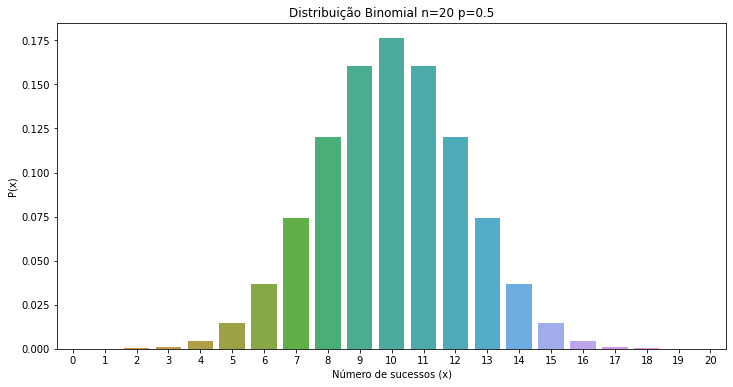

In [565]:
n = 20
p = 0.5

binomial_values = list( np.arange(n+1) )
dist = [ binom.pmf(val, n, p) for val in binomial_values]

plt.figure(figsize=(12,6))
plt.title('Distribuição Binomial n=20 p=0.5')
plt.xlabel('Número de sucessos (x)')
plt.ylabel('P(x)')
sns.barplot(binomial_values, dist);

Sendo X ~ Bin(n,p) uma variável aleatória que representa o número de sucessos obtidos, P(X <= 4) = P(X >= 16 ) = 0.005908 ~ 0,6%

In [567]:
prob = 0
for i in range(6):
    prob = prob + dist[i]
prob

0.02069473266601554

# Teste de Hipótese

Vamos realizar um teste de hipótese de uma calda, utilizando pvalor = 0.01

**H0: A feature a1 não apresenta relevância para o modelo**

**H1: A feature a1 apresenta relevância para o modelo**

A região crítica, que neste exemplo contém 1% dos dados, possui seu início entre x=15 e x=16, e estende-se até
x=20.

Como a feature a1 apresentou 16 sucessos, ela está localizada na região crítica, e portanto <br>
há evidência para rejeitarmos H0, ou seja, há evidência para considerarmos a feature a1 como <br>
relevante para o modelo, dizemos isso com um intervalo de confiança de 99%.

# Bibliografia

 An introduction to feature selection - https://machinelearningmastery.com/an-introduction-to-feature-selection/